# HugModel Example

You can install torchkeras using pip:
`pip install torchkeras`

Here is the mnist example using torchkeras.HugModel. 


In [1]:
import sys 
sys.path.append("..")


In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader


### 1, prepare data 

In [3]:
import torchvision 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_train = torch.utils.data.Subset(ds_train,indices=range(0,len(ds_train),30))

ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
ds_val = torch.utils.data.Subset(ds_val,indices=range(0,len(ds_val),30))

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False)



In [4]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([128, 1, 28, 28])
torch.Size([128])


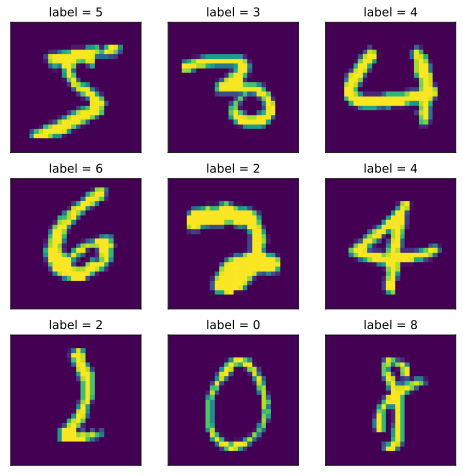

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


### 2, create the  model

In [6]:
def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        
        

### 3, train the  model

In [7]:
net = create_net()
loss_fn = nn.CrossEntropyLoss()
metrics_dict = {"acc":Accuracy()}


In [8]:
from importlib import reload 
from torchkeras import hugmodel
reload(hugmodel)
from torchkeras.hugmodel import HugModel 



In [9]:
#from torchkeras import HugModel
model = HugModel(net,loss_fn,metrics_dict)



/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


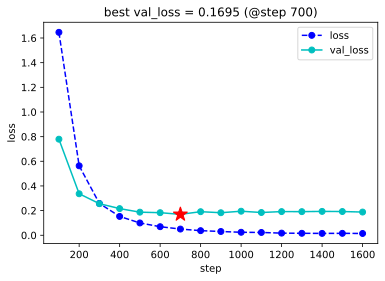

Step,Training Loss,Validation Loss,Acc
100,1.646200,0.779343,0.796407
200,0.563400,0.336605,0.898204
300,0.257800,0.256086,0.916168
400,0.152800,0.216270,0.919162
500,0.099800,0.187315,0.937126
600,0.069500,0.183184,0.931138
700,0.050300,0.169542,0.937126
800,0.037400,0.191208,0.943114
900,0.030600,0.182807,0.949102
1000,0.024200,0.195034,0.946108



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
'NoneType' object has no attribute 'cadam32bit_grad_fp32'
CUDA SETUP: Loading binary /Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...
dlopen(/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so, 0x0006): tried: '/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (not a mach-o file)


/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [11]:
%matplotlib inline 
model.fit(train_data=dl_train,
          val_data=dl_val,
          output_dir='output_dir',
          epochs=100,
          learning_rate=1e-3,
          logging_steps=100,
          monitor='val_loss',
          patience=5,
          mode='min',
          plot=True,
          wandb=False,
          #no_cuda=True
          #use_mps_device=True
         )


### 4, evaluate the model

In [21]:
model.evaluate(dl_val)


{'eval_loss': 0.14472568035125732, 'eval_acc': 0.961077868938446}

In [22]:
model.evaluate(dl_train)

{'eval_loss': 0.007294865325093269, 'eval_acc': 1.0}

### 5, use the model

y_pred =  3
y_prob =  0.9989043474197388


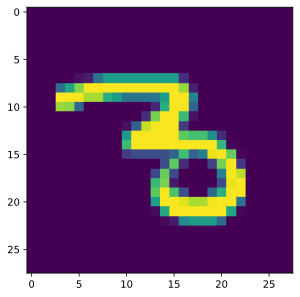

In [23]:
net = model.net
net.eval();

device = torch.device('cpu')
img,label = ds_train[1]
tensor = img.to(device)

y_pred = torch.argmax(net(tensor[None,...])) 
y_prob = torch.softmax(net(tensor[None,...]),dim=-1).max() 

img = img.permute(1,2,0)
plt.imshow(img)
print('y_pred = ', y_pred.item())
print('y_prob = ', y_prob.item())



### 6, save the model

In [24]:
#torch.save(model.net.state_dict(),'checkpoint.pt')
model.save_ckpt('checkpoint.pt')
